In [751]:
import torch
from spikingjelly.activation_based import neuron, surrogate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [752]:
input = torch.zeros([1000])
input[200:] = 500

In [753]:
#input_ = [0] * 200 + [10.] * 300

input_ = [0] * 200 + [10.] * 150 + [15.] * 250 + [8.] * 200 + [0] * 200

In [754]:
#data_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-U/001_NAB_id_1_Facility_tr_1007_1st_2014.csv'
data_path = '/home/hwkang/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'
df = pd.read_csv(data_path)
df = df.iloc[790:890, :]
data = df['0'].values
label = df['Label'].values

In [755]:
print(data.shape, label.shape)

(100,) (100,)


In [756]:
data = torch.tensor(data, dtype=torch.float32)

# normalization
#data = (data - data.mean()) / data.std()
data = (data - data.min()) / (data.max() - data.min())

data_diff = data[1:] - data[:-1]
data_diff = torch.cat((data_diff, torch.tensor([0.0])))

In [757]:
def min_max_to_current(x, I_min=0.0, I_max=20.0):
    x_min, x_max = x.min(), x.max()
    return I_min + (x - x_min) / (x_max - x_min) * (I_max - I_min)

#input_ = min_max_to_current(torch.tensor(data, dtype=torch.float32), I_min=0.0, I_max=20.0)

In [758]:
'''Izhikevich neuron

paper: https://www.izhikevich.org/publications/spikes.pdf
'''
class IZHI:
    def __init__(self, a=.1, b=.2, c=-65, d=8):
        self.a = a            
        self.b = b
        self.c = c
        self.d = d

        self.thrs = np.inf 
        self.v = -65
        self.u = -14

    '''Step to get the next voltage 

    Parameters
    -------

    dt: float 
        Time variantion [mS]

    I: float 
        Actual current [mA]

    method: integer
        Choose the diferentiation solve method  
        0 - Euler Method
        1 - Runge Kutta 4th Order method  
    '''
    def step(self, dt, I, method=0): 

        if method != 1 and method != 0:
            print("Invalid method\n0 - EULER\n1 - RK4\n")

        if self.v >= self.thrs:
            self.v = self.c
            self.u += self.d
        else: 
            if method == 1: 
                self.solve_rk4(dt, I)
            elif method == 0: 
                self.solve_euler(dt, I)

        return 1. if self.v >= self.thrs else 0.

    def solve_euler(self,dt,I): 
        dv = self.f_v(I,self.v,dt) 
        du = self.f_u(self.u,dt) 
        self.v += dv
        self.u += du

    def solve_rk4(self, dt, I):
        dv1 = self.f_v(I, self.v,dt) 
        dv2 = self.f_v(I, self.v + dv1*0.5,dt)
        dv3 = self.f_v(I, self.v + dv2*0.5,dt) 
        dv4 = self.f_v(I, self.v + dv3,dt) 
        dv  = 1/6*(dv1 + dv2*2 + dv3*2 + dv4) 
        

        du1 = self.f_u(self.u,dt) 
        du2 = self.f_u(self.u + du1*0.5,dt)
        du3 = self.f_u(self.u + du2*0.5,dt) 
        du4 = self.f_u(self.u + du3,dt) 
        du  = 1/6*(du1 + du2*2 + du3*2 + du4) 

        self.v += dv 
        self.u += du 
            
    def f_v(self, i, v, dt): 
        return (0.04 * v * v + 5 * v + 140 - self.u + i) *dt

    def f_u(self, u,dt): 
        return self.a * (self.b * self.v - u) *dt


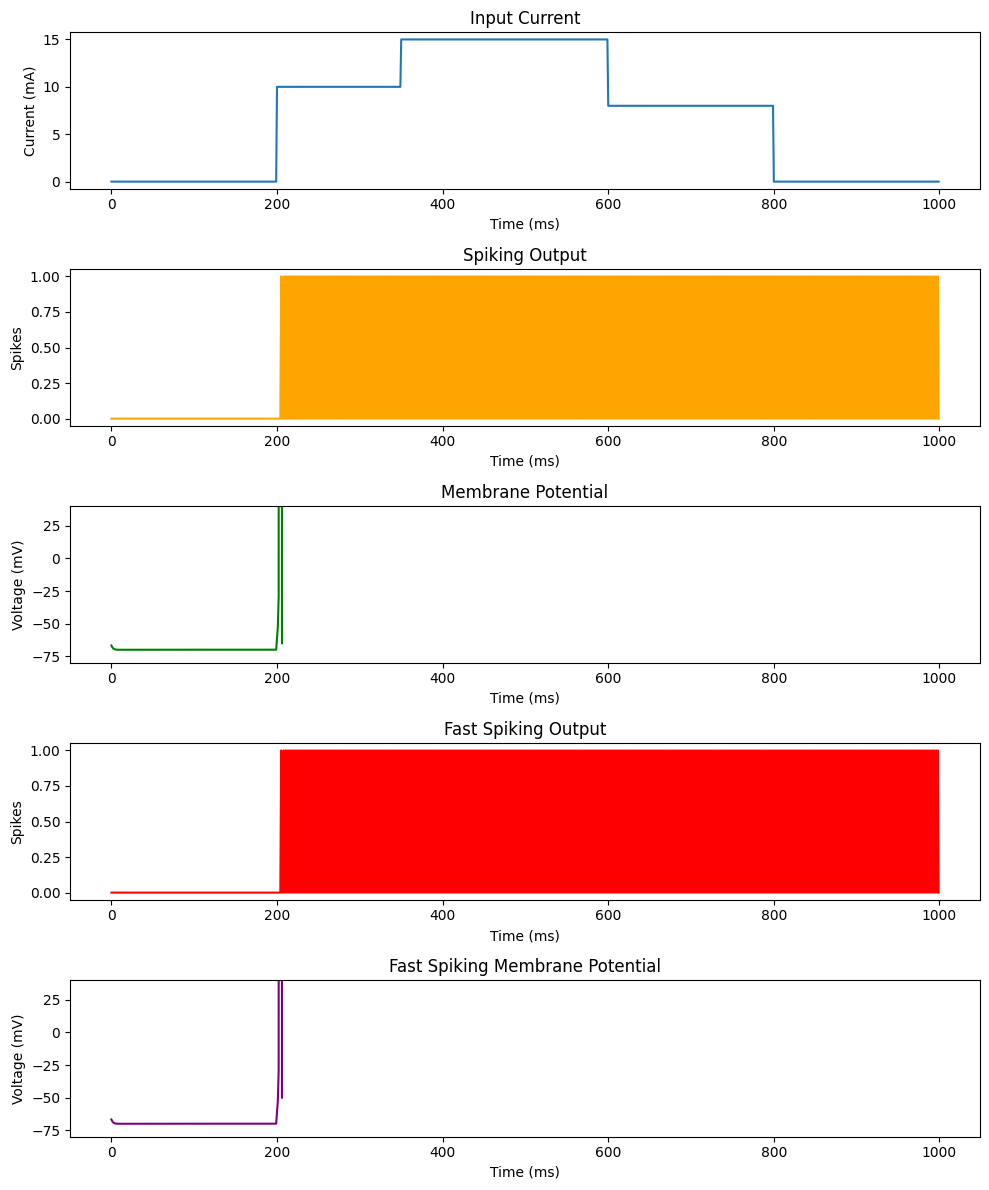

In [759]:
sa_i = IZHI(0.02, 0.2, -65, 6)
fa_i = IZHI(0.02, 0.2, -50, 1.5)
seq_out_sa_i = []
seq_v_sa_i = []
seq_out_fa_i = []
seq_v_fa_i = []
for i in range(len(input_)):
    out_sa_i = sa_i.step(1, input_[i], method=1)
    seq_out_sa_i.append(out_sa_i)
    seq_v_sa_i.append(sa_i.v)

    out_fa_i = fa_i.step(1, input_[i], method=1)
    seq_out_fa_i.append(out_fa_i)
    seq_v_fa_i.append(fa_i.v)

fig, axes = plt.subplots(5, 1, figsize=(10, 12))
axes[0].plot(input_, label='Input Current')
axes[0].set_title('Input Current')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Current (mA)')

axes[1].plot(seq_out_sa_i, label='Spikes', color='orange')
axes[1].set_title('Spiking Output')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Spikes')

axes[2].plot(seq_v_sa_i, label='Membrane Potential', color='green')
axes[2].set_title('Membrane Potential')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Voltage (mV)')
axes[2].set_ylim(-80, 40)

axes[3].plot(seq_out_fa_i, label='Spikes (Fast)', color='red')
axes[3].set_title('Fast Spiking Output')
axes[3].set_xlabel('Time (ms)')
axes[3].set_ylabel('Spikes')

axes[4].plot(seq_v_fa_i, label='Membrane Potential (Fast)', color='purple')
axes[4].set_title('Fast Spiking Membrane Potential')
axes[4].set_xlabel('Time (ms)')
axes[4].set_ylabel('Voltage (mV)')
axes[4].set_ylim(-80, 40)

plt.tight_layout()
plt.show()
plt.close()

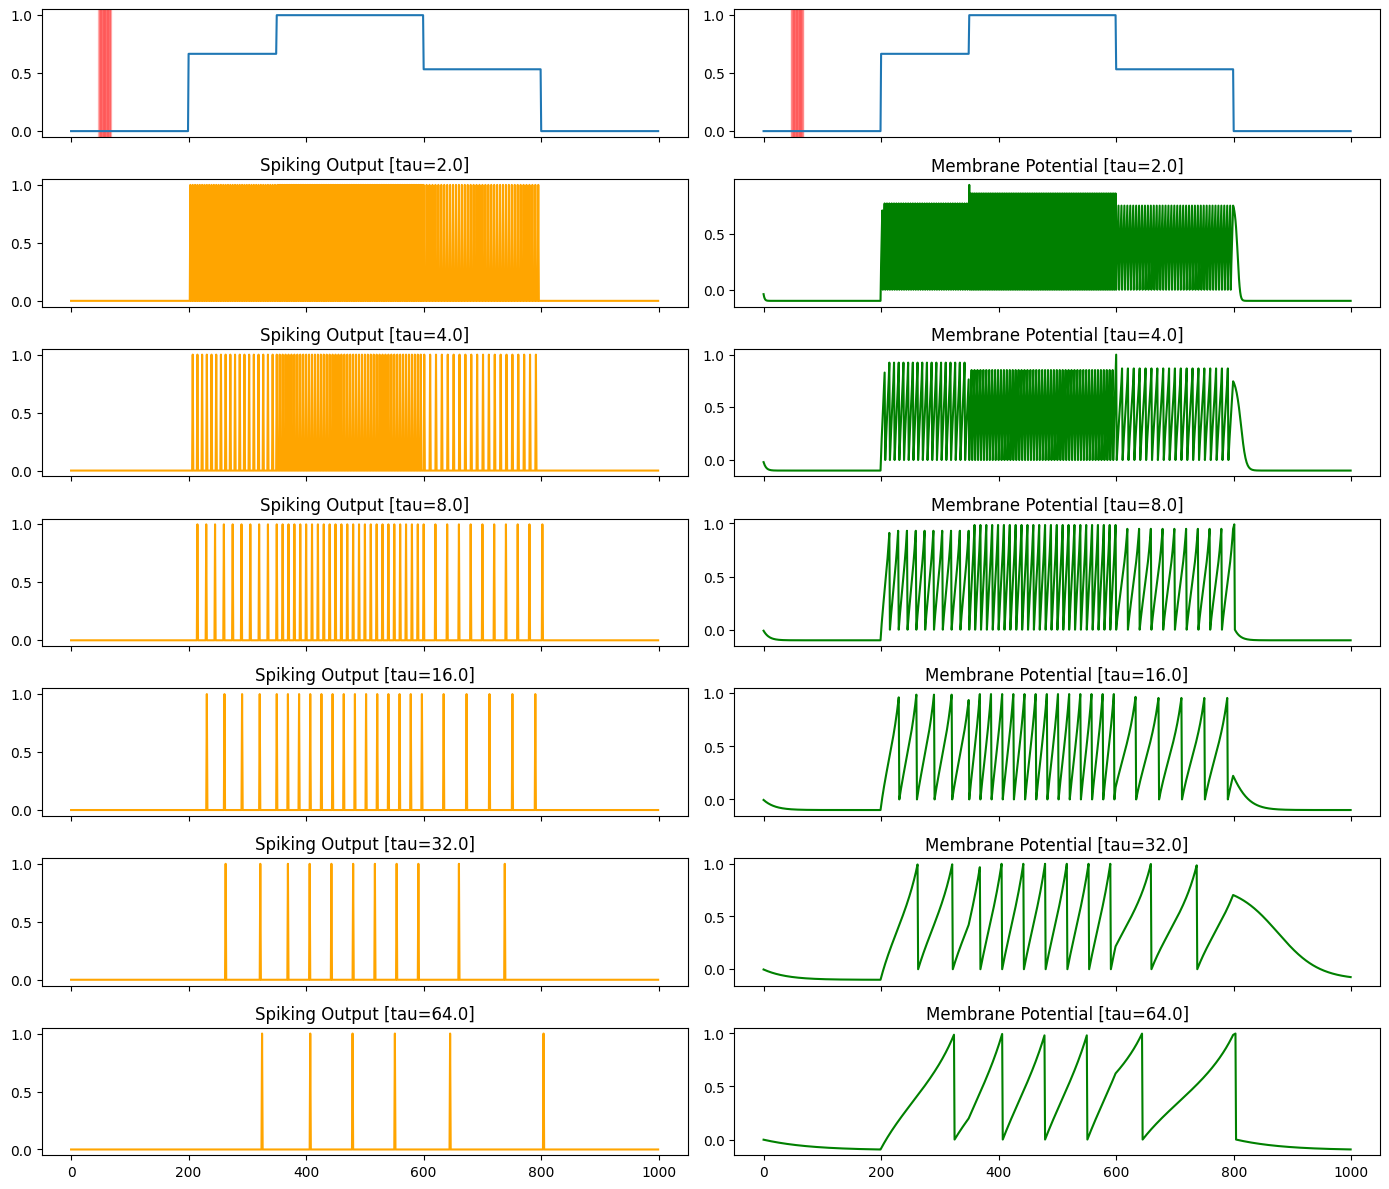

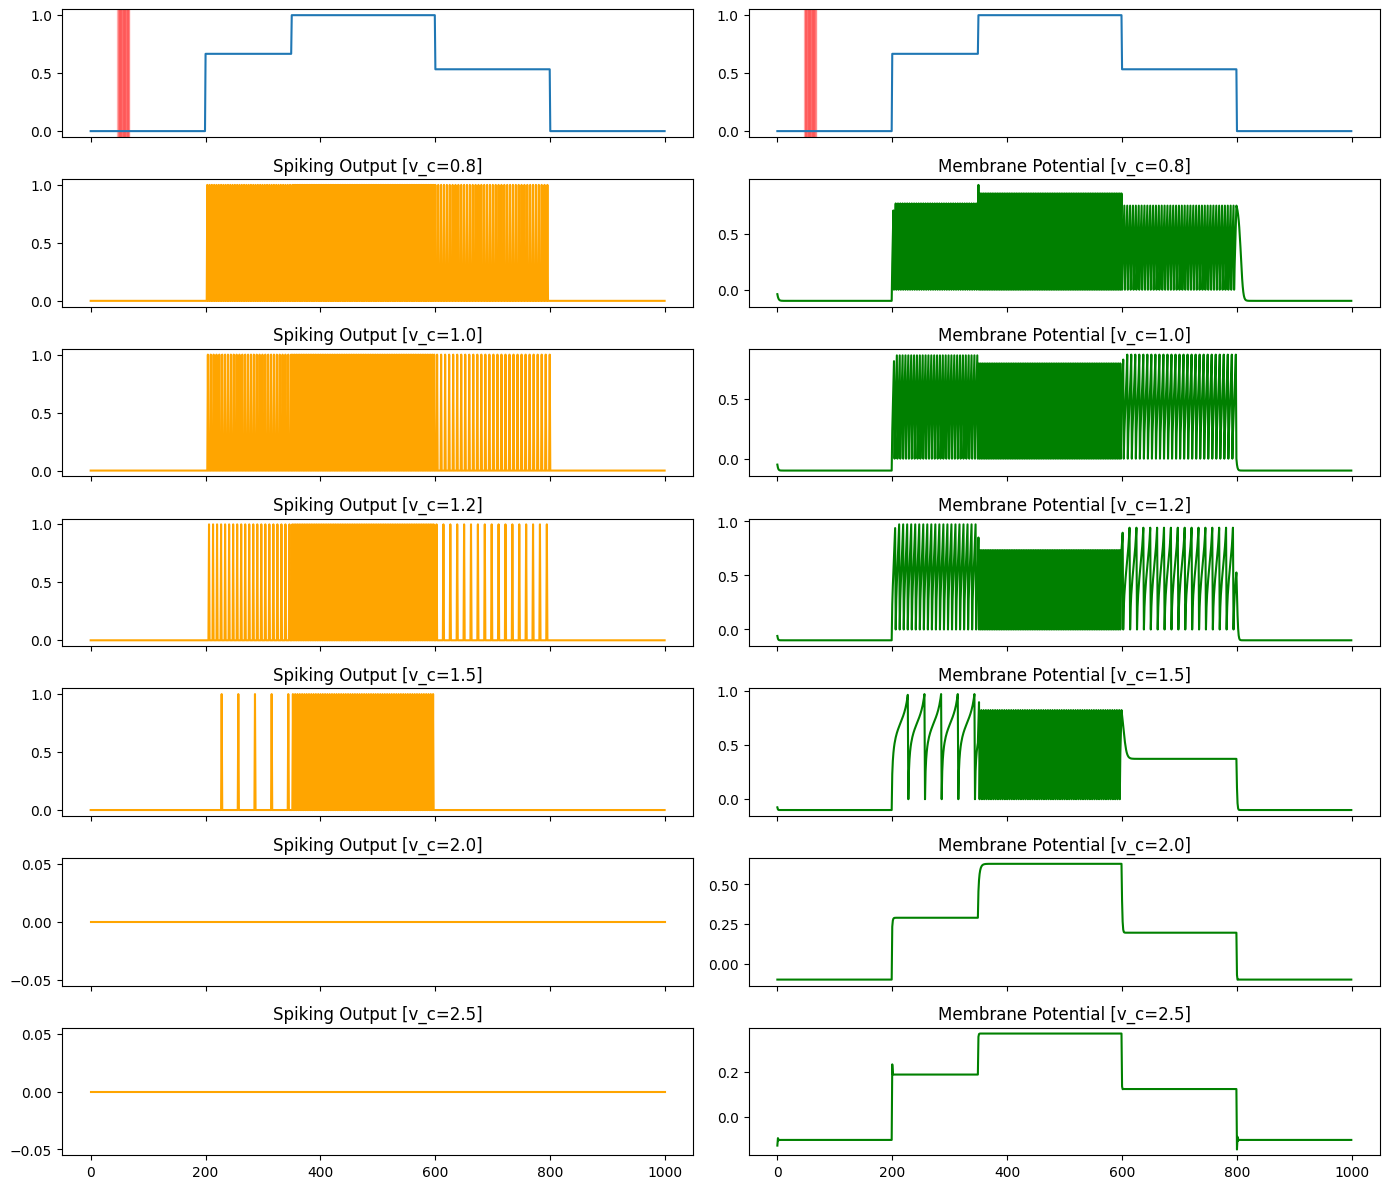

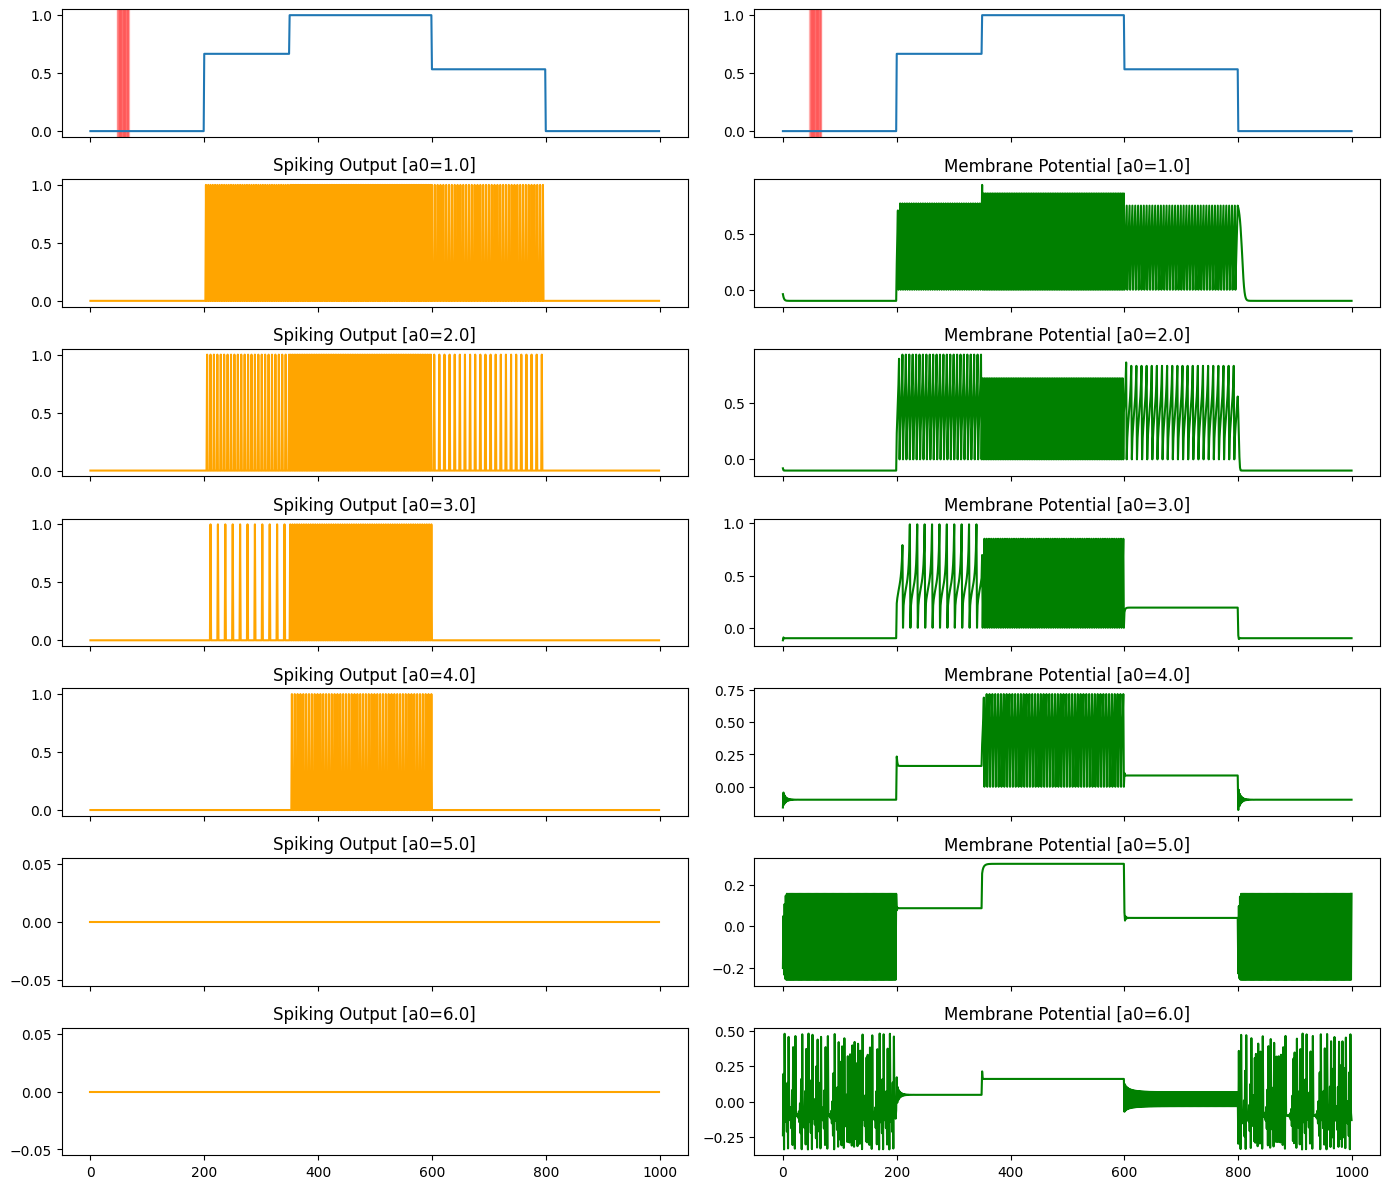

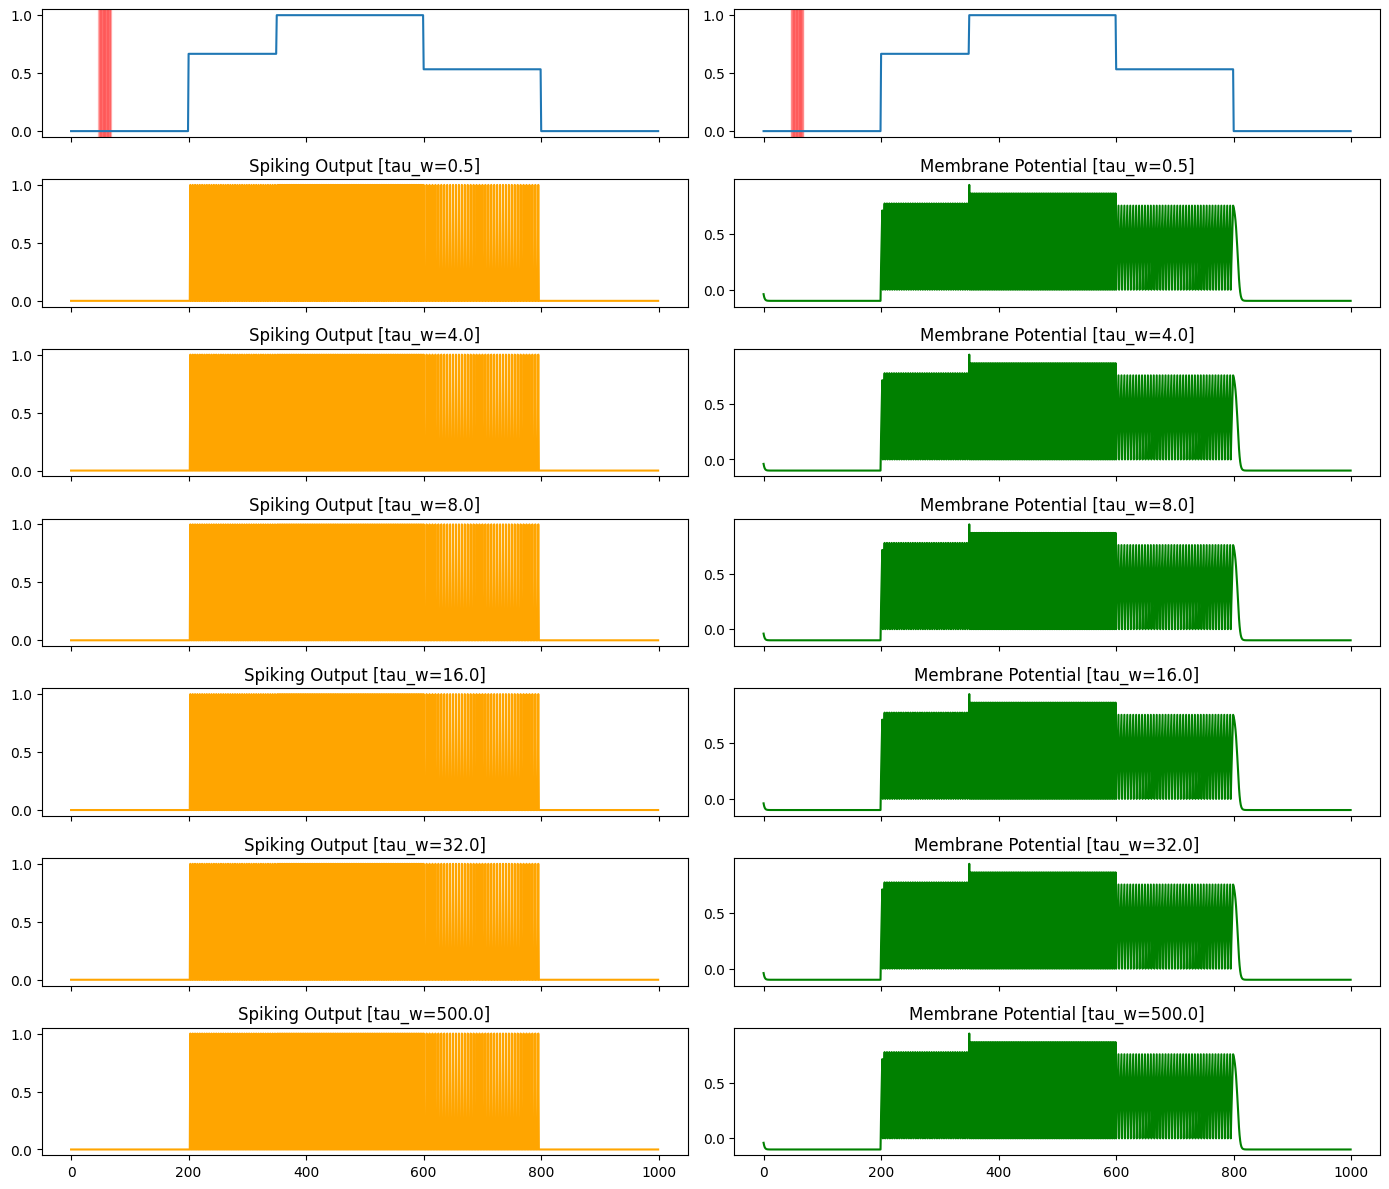

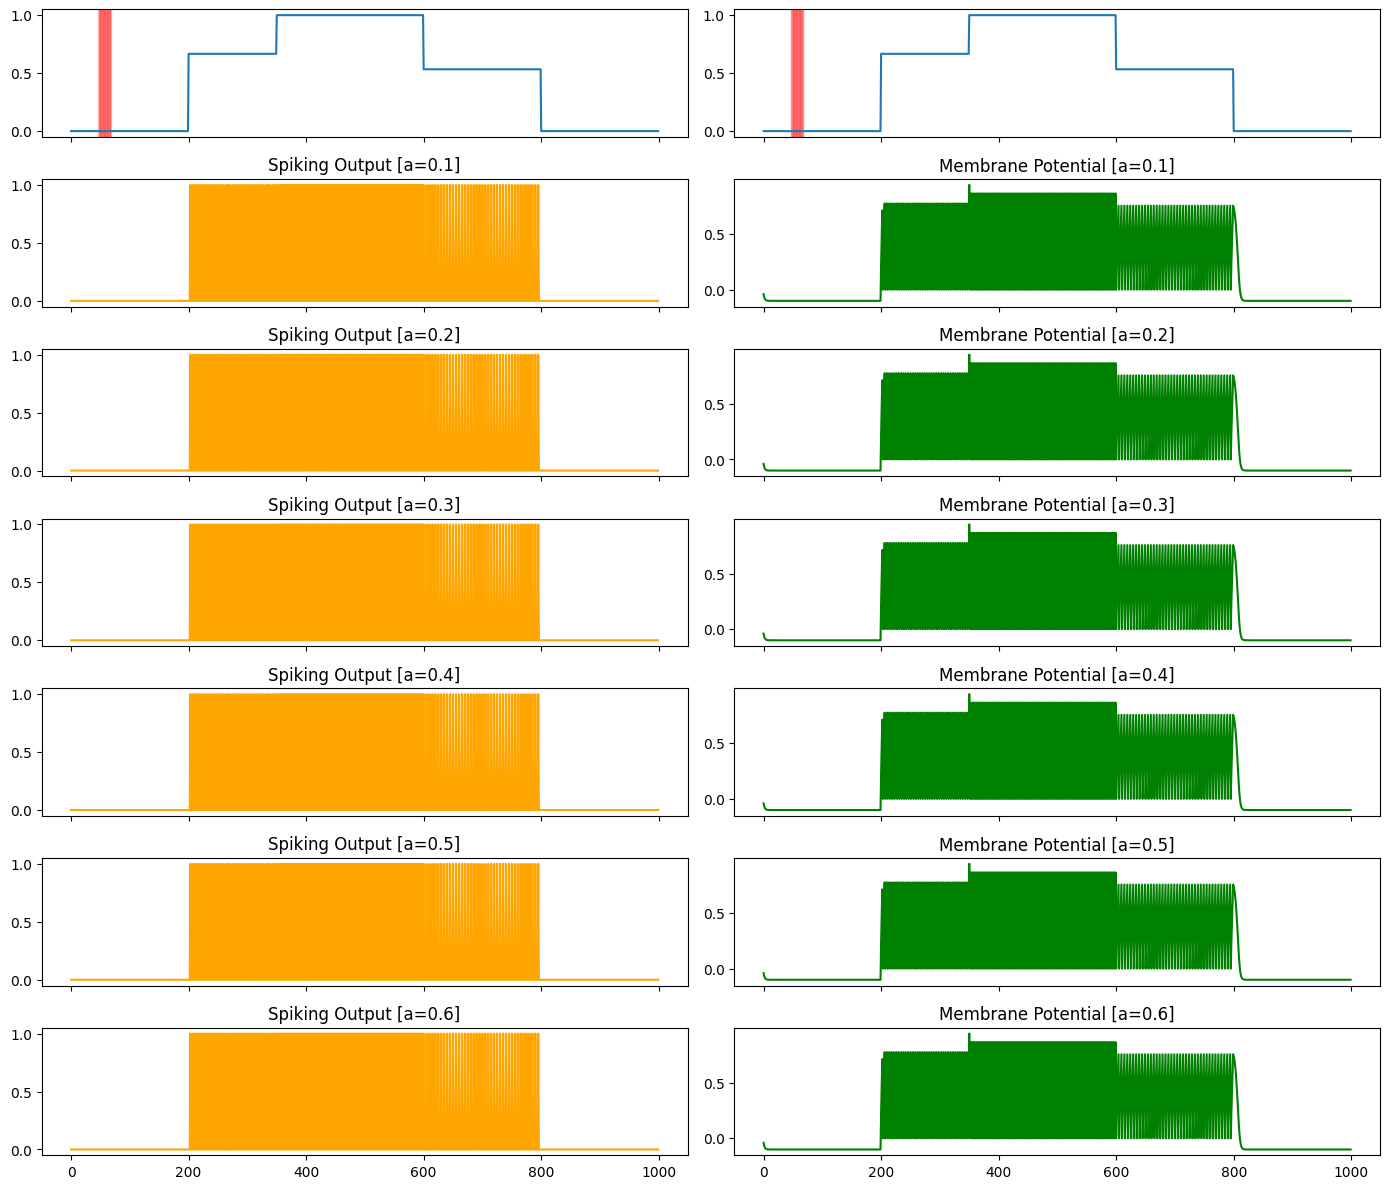

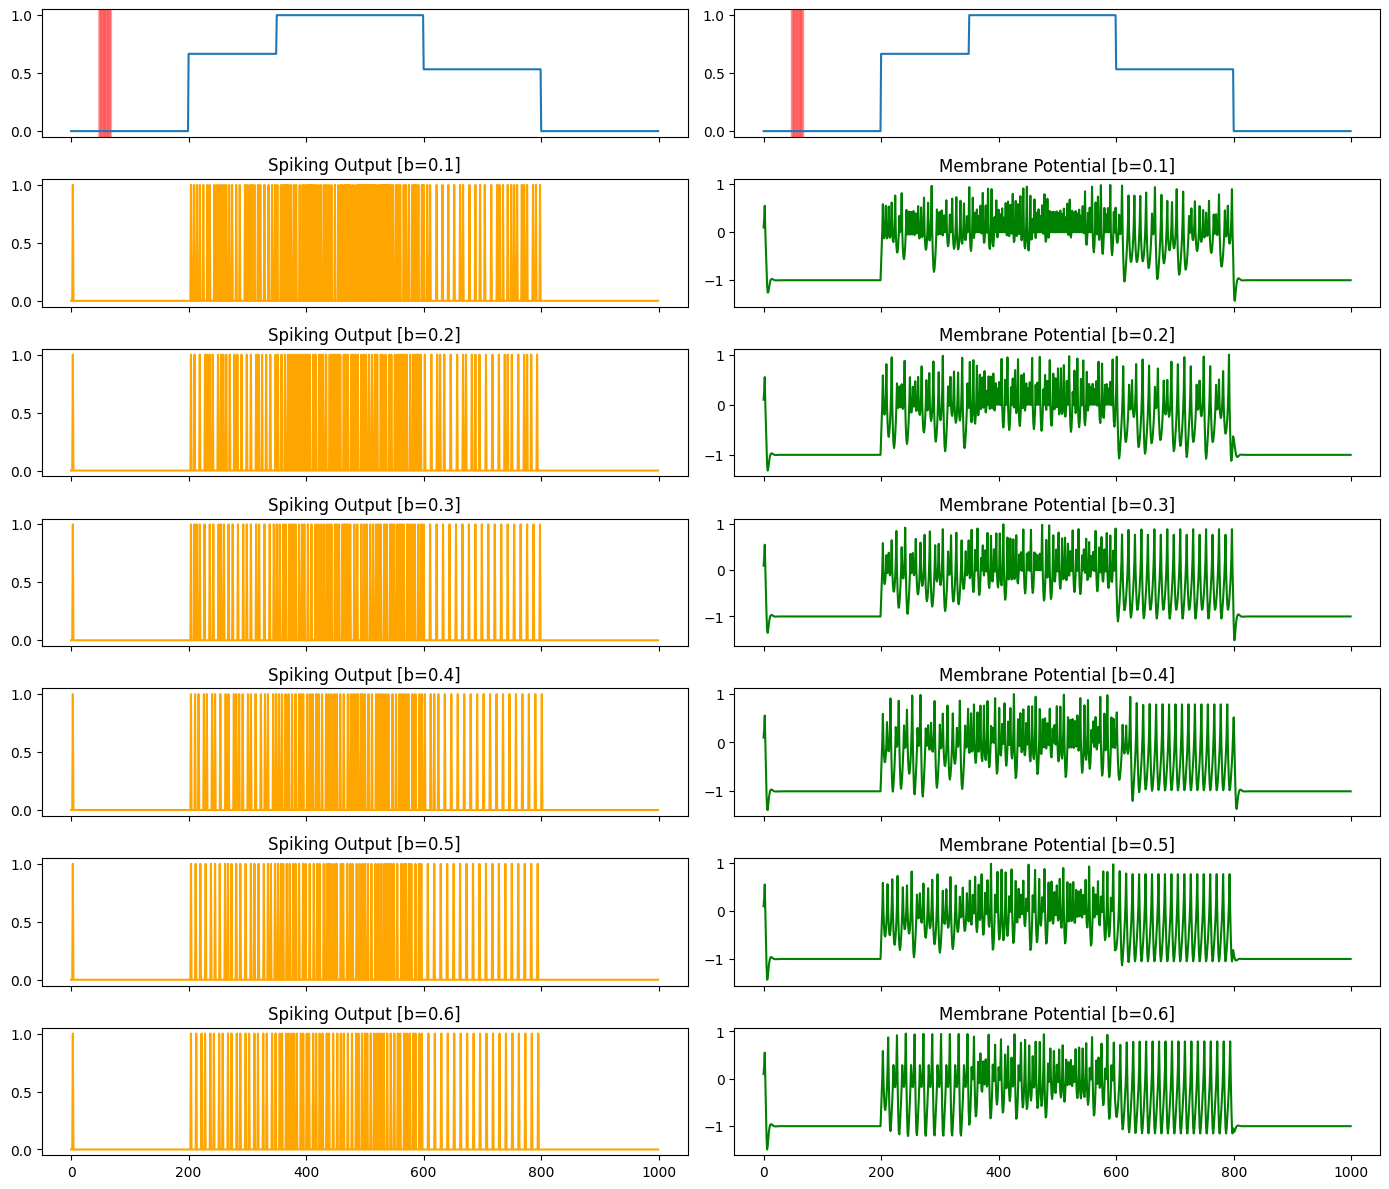

In [760]:
params_dict = {
    'tau': [2., 4., 8., 16., 32., 64.],
    'v_c': [0.8, 1.0, 1.2, 1.5, 2.0, 2.5],
    'a0': [1., 2., 3., 4., 5., 6.],
    'tau_w': [1/2, 4., 8., 16., 32., 500.],
    'a': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'b': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}
izh_neurons_dict = {
    'tau': [],
    'v_c': [],
    'a0': [],
    'tau_w': [],
    'a': [],
    'b': []
}

for k,v in params_dict.items():
    for param in v:
        if k == 'tau':
            izh_neuron = neuron.IzhikevichNode(tau=param, step_mode='m', store_v_seq=True)
        elif k == 'v_c':
            izh_neuron = neuron.IzhikevichNode(v_c=param, step_mode='m', store_v_seq=True)
        elif k == 'a0':
            izh_neuron = neuron.IzhikevichNode(a0=param, step_mode='m', store_v_seq=True)
        elif k == 'tau_w':
            izh_neuron = neuron.IzhikevichNode(tau_w=param, step_mode='m', store_v_seq=True)
        elif k == 'a':
            izh_neuron = neuron.IzhikevichNode(step_mode='m', store_v_seq=True)
        elif k == 'b':
            izh_neuron = neuron.IzhikevichNode(b=param, a=1., v_c=-2., step_mode='m', store_v_seq=True)

        izh_neurons_dict[k].append(izh_neuron) 

data = torch.tensor(input_, dtype=torch.float32)
data = (data - data.min()) / (data.max() - data.min())  # Normalize input data
#data[300:] = 1.0

for k, izh_neurons in izh_neurons_dict.items():
    fig, axes = plt.subplots(1 + len(izh_neurons), 2, figsize=(14, 2*len(izh_neurons)), sharex=True)
    axes[0, 0].plot(data.numpy(), label='Input Data')
    axes[0, 1].plot(data.numpy(), label='Input Data')
    for t in range(len(label)):
        if label[t] == 1:
            axes[0, 0].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)
            axes[0, 1].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)

    for i, izh_neuron in enumerate(izh_neurons):
        output = izh_neuron(data)
        output_v = izh_neuron.v_seq

        axes[i+1, 0].plot(output.numpy(), label='Spikes', color='orange')
        axes[i+1, 0].set_title(f'Spiking Output [{k}={params_dict[k][i]}]')

        axes[i+1, 1].plot(output_v.numpy(), label='Membrane Potential', color='green')
        axes[i+1, 1].set_title(f'Membrane Potential [{k}={params_dict[k][i]}]')

    plt.tight_layout()
    plt.savefig(f'/home/hwkang/dev-TSB-AD/TSB-AD/analyses/izhikevich/{k}.png')
    plt.show()
    plt.close()

In [761]:
lif = neuron.LIFNode(
    v_threshold=1.0,
    v_reset=0.0,
    tau=2.,
    step_mode='m',
    store_v_seq=True
)

In [762]:
from typing import Callable, Optional
class DynamicLIF(neuron.LIFNode):
    def __init__(self, tau: float = 2., decay_input: bool = True, v_threshold: float = 1.,
                 v_reset: Optional[float] = 0., surrogate_function: Callable = surrogate.Sigmoid(),
                 detach_reset: bool = False, step_mode='s', backend='torch', store_v_seq: bool = False):

        super().__init__(tau, decay_input, v_threshold, v_reset, surrogate_function, detach_reset, step_mode, backend, store_v_seq)

    def multi_step_forward(self, x_seq: torch.Tensor):
        inhibition_strength = 0.5
        T = x_seq.shape[0]
        y_seq = []
        x_seq_mod = x_seq.clone()
        if self.store_v_seq:
            v_seq = []
        for t in range(T):
            x_t = x_seq_mod[t]
            print(x_t)
            y = self.single_step_forward(x_t)
            y_seq.append(y)
            if self.store_v_seq:
                v_seq.append(self.v)

            # 다음 입력에 억제 반영 (피드백 억제)
            if t < T - 1:
                #print(y)
                x_seq_mod[t + 1] -= inhibition_strength * y * x_seq_mod[t]

        if self.store_v_seq:
            self.v_seq = torch.stack(v_seq)

        return torch.stack(y_seq)

In [763]:
dlif = DynamicLIF(
    v_threshold=0.5,
    v_reset=0.0,
    tau=float(2.0),
    step_mode='m',
    store_v_seq=True,
    decay_input=True
)

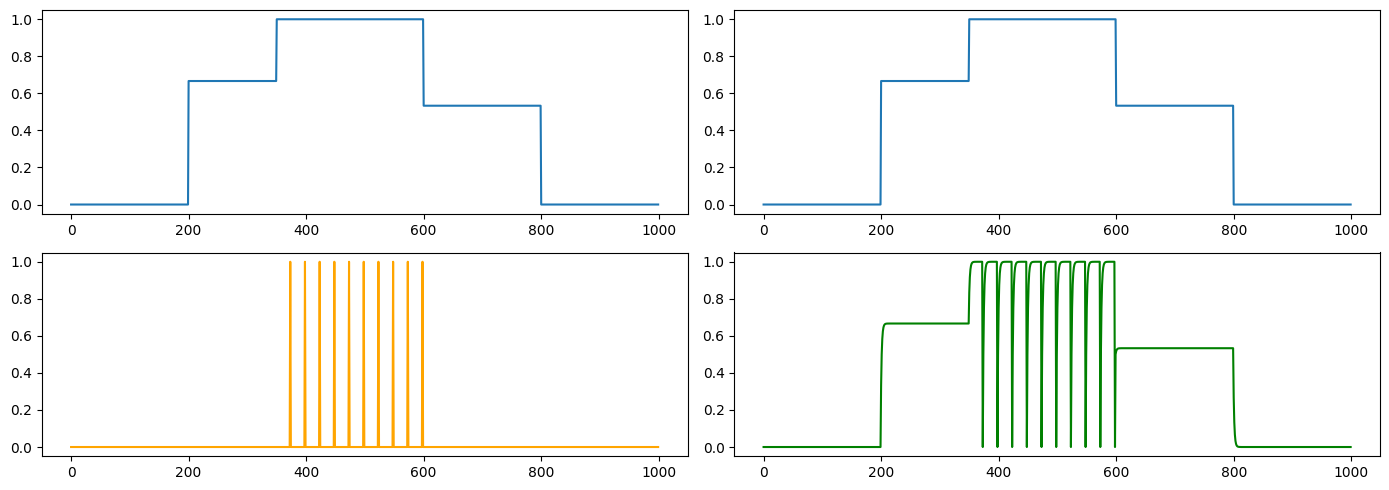

In [764]:
#data = torch.zeros([100])
#data[45:85] = 1.0


output = lif(data)
output_v = lif.v_seq

fig, axes = plt.subplots(2, 2, figsize=(14, 5))
axes[0, 0].plot(data.numpy(), label='Input Data')
axes[0, 1].plot(data.numpy(), label='Input Data')
axes[1, 0].plot(output.numpy(), label='Spikes', color='orange')
axes[1, 1].plot(output_v.numpy(), label='Membrane Potential', color='green')

plt.tight_layout()
plt.show()

In [765]:
'''
data = torch.zeros([100])
data[45:85] = 1.0

output = dlif(data)
output_v = dlif.v_seq

fig, axes = plt.subplots(2, 2, figsize=(14, 5))
axes[0, 0].plot(data, label='Input Data')
axes[0, 1].plot(data.numpy(), label='Input Data')
axes[1, 0].plot(output.numpy(), label='Spikes', color='orange')
axes[1, 1].plot(output_v.numpy(), label='Membrane Potential', color='green')

plt.tight_layout()
plt.show()
'''

"\ndata = torch.zeros([100])\ndata[45:85] = 1.0\n\noutput = dlif(data)\noutput_v = dlif.v_seq\n\nfig, axes = plt.subplots(2, 2, figsize=(14, 5))\naxes[0, 0].plot(data, label='Input Data')\naxes[0, 1].plot(data.numpy(), label='Input Data')\naxes[1, 0].plot(output.numpy(), label='Spikes', color='orange')\naxes[1, 1].plot(output_v.numpy(), label='Membrane Potential', color='green')\n\nplt.tight_layout()\nplt.show()\n"